In [26]:
import pandas as pd
import numpy as np
import scipy
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
data = loadmat("data.mat")
X = data["X"]
y = data["y"]
scaler = StandardScaler()
X = scaler.fit_transform(X)
joined = np.column_stack((X, y))


In [3]:
def sigmoid(x):
    return np.clip(scipy.special.expit(x), 1e-15, 1-1e-15)
def next_weight_grad(X, w, y, lam, lr):
    """
    lr = learning rate
    lam = lambda or l2 regularization term parameter
    w = weight vector
    X = training data
    y = labels
    """
    s = sigmoid(X.dot(w)) 
    # clip so we avoid large oscillating updates to our weight vector
    if type(y) is np.float64:
        grad = np.clip(X.T.dot(s - y) + (lam) * w, -0.5, 5)
    else:
        grad = np.clip(X.T.dot(s - y) + (lam / len(y)) * w, -0.5, 0.5) 
    
    w = w - lr * grad
    return w

class LogisticRegression:
    def __init__(self, Xy, X_val, y_val):
        self.Xy = Xy
        # add bias dimension
        self.X = np.column_stack((Xy[:, 0:-1], np.ones(Xy[:, 0:-1].shape[0])))
        self.y = Xy[:, -1]
        # random weight vector and make values small
        self.w = np.random.randn(self.X.shape[1]) * 0.01
        self.X_val = np.column_stack((X_val, np.ones(X_val.shape[0])))
        self.y_val = y_val
        self.scores = []

    def eval(self, threshold):
        predictions = self.X_val.dot(self.w)
        threshed_predictions = np.where(predictions > threshold, 1, 0)
        return accuracy_score(threshed_predictions, self.y_val)

    def loss(self, w, lam):
        s = sigmoid(self.X.dot(w))
        loss_term = -1 * (self.y.dot(np.log(s)) + (1-self.y).dot(np.log(1-s)))
        l2 = (lam / (2 * len(self.y))) * (np.linalg.norm(w) ** 2)
        return loss_term + l2

    def train(self, lam, lr, epochs, method, schedule=False):

        # keep a stack of our 5 most recent differences in scores so we can end loop early when we converge
        # reset weight vector and loss score array
        prev = []
        self.scores = []
        self.w = np.random.randn(self.X.shape[1]) * 0.01
        
        if method == "gd":
            for epoch in range(epochs):

                print(f"Epoch: {epoch}")

                next_w = next_weight_grad(X=self.X, w=self.w, y=self.y, lam=lam, lr=lr)
                next_loss = self.loss(next_w, lam)
                prev.append(abs(self.loss(self.w, lam)-next_loss))

                if len(prev) > 5:
                    prev.pop(0)
                
                if (len(prev) == 5 and np.std(prev) <= 0.01):
                    print(f"Gradient descent converged in {epoch} epochs")
                    self.w = next_w
                    break
                else:
                    print("Diff: ", abs(self.loss(self.w, lam)-self.loss(next_w, lam)))
                    print("Loss", self.loss(next_w, lam))
                    self.scores.append(self.loss(next_w, lam))
                    self.w = next_w
            if len(self.scores) >= epochs:
                print("Maximum epochs reached")

        elif method == "sgd":
            for epoch in range(epochs):
                print(f"Epoch: {epoch}")
                indices = np.random.permutation(len(self.y))
                X_shuffled = self.X[indices]
                y_shuffled = self.y[indices]

                # Process each training example individually (SGD)
                for i in range(len(self.y)):
                    x = X_shuffled[i]  
                    y = y_shuffled[i]  
                    if schedule:
                        lr = lr / (1 + 0.01 * epoch)
                    self.w = next_weight_grad(x, self.w, y, lam, lr)
                
                epoch_loss = self.loss(self.w, lam)
                self.scores.append(epoch_loss)
                
                if len(self.scores) > 1:
                    epoch_loss_diff = abs(self.scores[-2] - self.scores[-1])
                    print("Diff: ", epoch_loss_diff)
                    print("Loss: ", epoch_loss)
                    prev.append(epoch_loss_diff)
                    
                    if len(prev) > 5:
                        prev.pop(0)

                    if len(prev) == 5 and np.mean(prev) <= 0.5:
                        print(f"Gradient descent converged in {epoch} epochs")
                        break
            if len(self.scores) >= epochs:
                print("Maximum epochs reached")

In [4]:
np.random.seed(189)
np.random.shuffle(joined)
X = joined[:, 0:-1]
y = joined[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=189)
lr = LogisticRegression(np.column_stack((X_train, y_train)), X_val=X_val, y_val=y_val)


In [5]:
lr.train(lr=.001,lam=0.04, epochs = 1000, method = "sgd")
lr.eval(0.5)

Epoch: 0
Epoch: 1
Diff:  244.50714397679542
Loss:  660.4738320588791
Epoch: 2
Diff:  90.47914781205384
Loss:  569.9946842468253
Epoch: 3
Diff:  43.272731304015906
Loss:  526.7219529428094
Epoch: 4
Diff:  23.5752710965196
Loss:  503.14668184628977
Epoch: 5
Diff:  13.960695877175226
Loss:  489.18598596911454
Epoch: 6
Diff:  8.009159595786798
Loss:  481.17682637332774
Epoch: 7
Diff:  5.348242692747817
Loss:  475.8285836805799
Epoch: 8
Diff:  3.1668837831518317
Loss:  472.6616998974281
Epoch: 9
Diff:  2.318299229845252
Loss:  470.34340066758284
Epoch: 10
Diff:  1.540022893578623
Loss:  468.8033777740042
Epoch: 11
Diff:  0.8758231718018692
Loss:  467.92755460220235
Epoch: 12
Diff:  0.7293108577154044
Loss:  467.19824374448694
Epoch: 13
Diff:  0.23800727456062987
Loss:  466.9602364699263
Epoch: 14
Diff:  0.14199022337095357
Loss:  466.81824624655536
Epoch: 15
Diff:  0.5766668304691507
Loss:  466.2415794160862
Epoch: 16
Diff:  0.2381513368738979
Loss:  466.0034280792123
Gradient descent conve

0.991

Text(0.5, 1.0, 'Stochastic Gradient Descent Loss Curve')

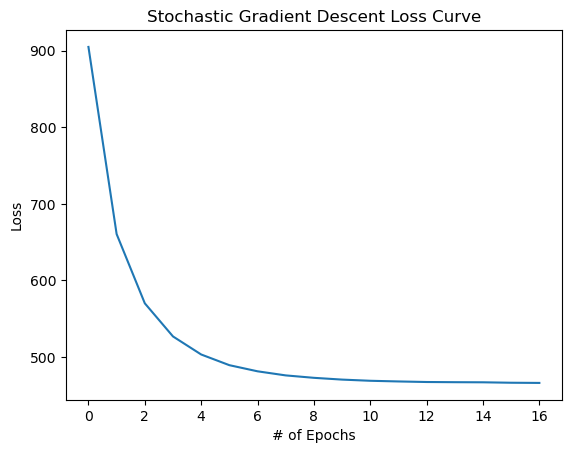

In [6]:
plt.plot(range(len(lr.scores)), lr.scores)
plt.xlabel("# of Epochs")
plt.ylabel("Loss")
plt.title("Stochastic Gradient Descent Loss Curve")

In [7]:
lr.train(lr=.01,lam=0.04, epochs = 20000, method = "gd")
lr.eval(0.5)

Epoch: 0
Diff:  44.657334104751044
Loss 2717.548803077488
Epoch: 1
Diff:  43.833989476846
Loss 2673.714813600642
Epoch: 2
Diff:  43.0123711167148
Loss 2630.7024424839274
Epoch: 3
Diff:  42.193297372586585
Loss 2588.509145111341
Epoch: 4
Diff:  41.377567751330844
Loss 2547.13157736001
Epoch: 5
Diff:  40.56595766973987
Loss 2506.56561969027
Epoch: 6
Diff:  39.75921376192855
Loss 2466.8064059283415
Epoch: 7
Diff:  38.958049816623316
Loss 2427.848356111718
Epoch: 8
Diff:  38.20351238925787
Loss 2389.6448437224603
Epoch: 9
Diff:  37.45012778379669
Loss 2352.1947159386636
Epoch: 10
Diff:  36.76123972311825
Loss 2315.4334762155454
Epoch: 11
Diff:  36.03863966842846
Loss 2279.394836547117
Epoch: 12
Diff:  35.32314526601613
Loss 2244.071691281101
Epoch: 13
Diff:  34.61060958247481
Loss 2209.461081698626
Epoch: 14
Diff:  33.92995941958952
Loss 2175.5311222790365
Epoch: 15
Diff:  33.238106089417215
Loss 2142.2930161896193
Epoch: 16
Diff:  32.53809876245941
Loss 2109.75491742716
Epoch: 17
Diff:  3

0.992

Text(0.5, 1.0, 'Full-Batch Gradient Descent Loss Curve')

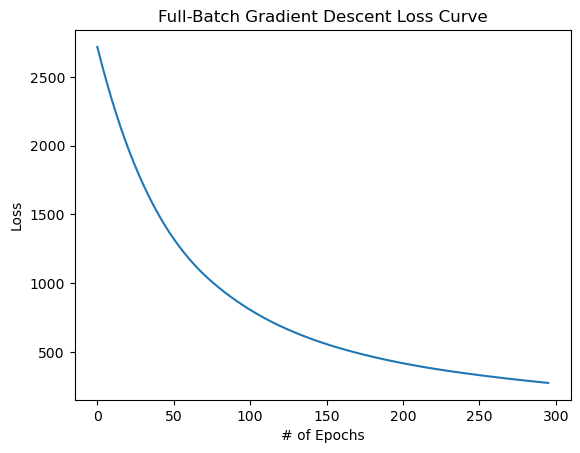

In [8]:
plt.plot(np.arange(len(lr.scores)), lr.scores)
plt.xlabel("# of Epochs")
plt.ylabel("Loss")
plt.title("Full-Batch Gradient Descent Loss Curve")

In [9]:
lr.train(lr=.01,lam=0.04, epochs = 1000, method = "sgd", schedule=True)
lr.eval(0.5)

Epoch: 0
Epoch: 1
Diff:  1.376250426149852
Loss:  471.3340012351194
Epoch: 2
Diff:  0.0
Loss:  471.3340012351194
Epoch: 3
Diff:  0.0
Loss:  471.3340012351194
Epoch: 4
Diff:  0.0
Loss:  471.3340012351194
Epoch: 5
Diff:  0.0
Loss:  471.3340012351194
Gradient descent converged in 5 epochs


0.991

Text(0.5, 1.0, 'Scheduled Stochastic Gradient Descent Loss Curve')

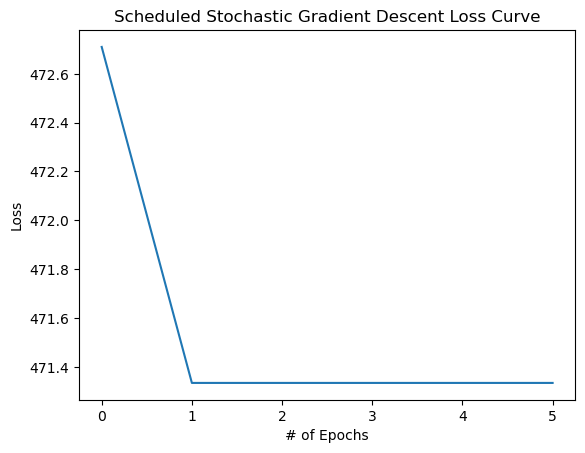

In [10]:
plt.plot(np.arange(len(lr.scores)), lr.scores)
plt.xlabel("# of Epochs")
plt.ylabel("Loss")
plt.title("Scheduled Stochastic Gradient Descent Loss Curve")

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=189)
kaggle_lr = LogisticRegression(np.column_stack((X_train, y_train)), X_val, y_val)
lr.train(lr=.01,lam=0.04, epochs = 1000, method = "sgd", schedule=True)
lr.eval(0.5)

Epoch: 0
Epoch: 1
Diff:  246.35135262571555
Loss:  661.7991286218753
Epoch: 2
Diff:  90.56686134499182
Loss:  571.2322672768835
Epoch: 3
Diff:  43.68735120202746
Loss:  527.544916074856
Epoch: 4
Diff:  23.92600848445238
Loss:  503.61890759040364
Epoch: 5
Diff:  13.87610326046621
Loss:  489.7428043299374
Epoch: 6
Diff:  8.69917957104451
Loss:  481.0436247588929
Epoch: 7
Diff:  5.288373430536353
Loss:  475.75525132835656
Epoch: 8
Diff:  3.499766840916948
Loss:  472.2554844874396
Epoch: 9
Diff:  1.9054578787086598
Loss:  470.35002660873096
Epoch: 10
Diff:  1.647819802133938
Loss:  468.702206806597
Epoch: 11
Diff:  1.064810858530791
Loss:  467.6373959480662
Epoch: 12
Diff:  0.4937091777747469
Loss:  467.1436867702915
Epoch: 13
Diff:  0.014198246542378001
Loss:  467.15788501683386
Epoch: 14
Diff:  0.683954594283648
Loss:  466.4739304225502
Epoch: 15
Diff:  0.11566641240170839
Loss:  466.3582640101485
Gradient descent converged in 15 epochs


0.991

In [30]:
kaggle_X = data["X_test"]
kaggle_X = scaler.fit_transform(kaggle_X)
kaggle_X = np.column_stack((kaggle_X, np.ones(kaggle_X.shape[0])))
predictions = kaggle_X.dot(lr.w)
threshed_predictions = np.where(predictions > 0.5, 1, 0)
threshed_predictions

threshed_predictions = threshed_predictions.astype(int)
df = pd.DataFrame({'Category': threshed_predictions})
df.index += 1
df.to_csv("predictions.csv", index_label='ID')